In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [80]:
def predict(w, x, b):
    return np.dot(x, w) + b

def MSE(w, x, b, y):
    return np.mean((y - predict(w, x, b)) ** 2)/10000

def random_split(data, ratio_x, ratio_y):
    size = data.shape[0]
    size_x = int(size * ratio_x)
    size_y = int(size * ratio_y)
    all_indices = np.arange(size)
    np.random.shuffle(all_indices)
    indices_y = all_indices[:size_y]
    indices_x = all_indices[size_y:size_y + size_x]
    data_x = data[indices_x]
    data_y = data[indices_y]
    return data_x, data_y

def normalize_features(x):
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    x_normalized = (x - mean) / std
    return x_normalized, mean, std


def compute_gradient(w, x, b, y):
    m = x.shape[0]
    predictions = predict(w, x, b)
    error = predictions - y
    w_gradient = np.dot(x.T, error) / m
    b_gradient = np.sum(error) / m
    return w_gradient, b_gradient


def cost_function(w, x, b, y):
    m = x.shape[0]
    predictions = predict(w, x, b)
    squared_errors = np.square(predictions - y)
    total_cost = np.sum(squared_errors) / (2 * m)
    return total_cost/1000


def gradient_descent(w, x, b, y, iterations, alpha):
    J_history = []
    b_history = []
    w_history = []
    m = x.shape[0]
    for i in range(iterations):
        w_gradient, b_gradient = compute_gradient(w, x, b, y)
        w -= alpha * w_gradient
        b -= alpha * b_gradient
        J_history.append(cost_function(w, x, b, y))
        w_history.append(w.copy())
        b_history.append(b)
        if i % 10 == 0:
            print(f'Iteration {i}, Cost {J_history[-1]}, W: {w}, B: {b}')
    return w_history, b_history, J_history, w, b


In [81]:
df = pd.read_csv('data.csv')
x_train_norm, mean, std = normalize_features(df.iloc[:, :-1].values)
y_train = df.iloc[:, -1].values
w_init = np.zeros(x_train_norm.shape[1])
b_init = 0
iters = 600
alpha = 0.01
w_hist, b_hist, J_hist, w_final, b_final = gradient_descent(w_init, x_train_norm, b_init, y_train, iters, alpha)

print('Final W:', w_final)
print('Final B:', b_final)

Iteration 0, Cost 73660366.11384715, W: [ 628.31832006  429.05850585 -441.79551754 -360.93673068], B: 3823.0769230769233
Iteration 10, Cost 59950352.41472692, W: [ 6242.18706938  4022.55506879 -4184.63335649 -3325.84645059], B: 40012.990487244555
Iteration 20, Cost 48892447.76273828, W: [10844.36673768  6579.78389104 -6927.02037906 -5342.24859366], B: 72742.49961079576
Iteration 30, Cost 39933134.01325896, W: [14670.51019037  8365.13302706 -8928.18623383 -6664.67965452], B: 102342.48098597258
Iteration 40, Cost 32651161.208882026, W: [ 17897.56839393   9575.89044579 -10381.05277292  -7482.13870627], B: 129112.17356227696
Iteration 50, Cost 26719475.36144428, W: [ 20658.64540195  10359.29280291 -11429.12211601  -7934.80096959], B: 153322.20368178294
Iteration 60, Cost 21880289.372236088, W: [ 23054.08034563  10825.24008839 -12179.06867497  -8126.47857007], B: 175217.32095728733
Iteration 70, Cost 17928146.83655582, W: [ 25159.71555389  11055.77814937 -12710.12763369  -8133.91005087], B:

In [82]:
x_predict = np.array([2500, 4, 10, 5])
x_predict_normalized = (x_predict - mean) / std
print('Prediction:', predict(w_final, x_predict_normalized, b_final))

Prediction: 486240.6122186702


In [85]:
x_test = pd.read_csv('test_data.csv')
x_test_norm, mean, std = normalize_features(x_test.iloc[:, :-1].values)
y_test = x_test.iloc[:, -1].values
y_pred = predict(w_final, x_test_norm, b_final)
mse = MSE(w_final, x_test_norm, b_final, y_test)
mse_train = MSE(w_final, x_train_norm, b_final, y_train)
print('Mean Squared Error on Test Set:', mse)
print('Mean Squared Error on Train Set:', mse_train*10)
import numpy as np

def k_fold_cross_validation(x, y, k, iterations, alpha):
    fold_size = x.shape[0] // k
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    
    folds = [indices[i * fold_size:(i + 1) * fold_size] for i in range(k)]
    
    best_alpha = None
    best_iterations = None
    best_cost = float('inf')
    
    for alpha_val in alpha:
        for iter_val in iterations:
            fold_costs = []
            for i in range(k):
                val_indices = folds[i]
                train_indices = np.concatenate(folds[:i] + folds[i+1:])
                
                x_train, y_train = x[train_indices], y[train_indices]
                x_val, y_val = x[val_indices], y[val_indices]
                
                # Normalize features
                x_train_norm, mean, std = normalize_features(x_train)
                x_val_norm = (x_val - mean) / std
                
                # Initialize weights and bias
                w = np.zeros(x_train_norm.shape[1])
                b = 0
                
                # Run gradient descent
                w_history, b_history, J_history, w_final, b_final = gradient_descent(
                    w, x_train_norm, b, y_train, iter_val, alpha_val
                )
                
                # Compute cost on a validation set
                x_val_norm = (x_val - mean) / std
                cost = cost_function(w_final, x_val_norm, b_final, y_val)
                fold_costs.append(cost)
            
            avg_cost = np.mean(fold_costs)
            if avg_cost < best_cost:
                best_cost = avg_cost
                best_alpha = alpha_val
                best_iterations = iter_val
    
    return best_alpha, best_iterations

alphas = [0.001, 0.01, 0.1, 0.5, 0.05, 0.034]
iterations = [100, 500, 1000, 5000, 10000]
k = 5
alpha, best_iters = k_fold_cross_validation(x_train_norm, y_train, 5, iterations, alphas)
print(alpha, best_iters)

Mean Squared Error on Test Set: 135516.9455231653
Mean Squared Error on Train Set: 148205.36725998222
Iteration 0, Cost 80192832.52065119, W: [ 58.91883036  36.23922254 -34.50093971 -22.68306452], B: 396.25
Iteration 10, Cost 78577455.57861969, W: [ 642.72229361  392.60050809 -374.2233742  -244.5019858 ], B: 4337.021500670384
Iteration 20, Cost 76995716.433474, W: [1216.88780379  738.20827919 -704.51753236 -457.39908893], B: 8238.562148985584
Iteration 30, Cost 75446859.24939653, W: [ 1781.62916132  1073.35876921 -1025.64126823  -661.64052395], B: 12101.262492780272
Iteration 40, Cost 73930147.97054727, W: [ 2337.15474714  1398.34015995 -1337.84543355  -857.4850484 ], B: 15925.509191938634
Iteration 50, Cost 72444865.67217635, W: [ 2883.66766649  1713.43279979 -1641.37406739 -1045.18422883], B: 19711.685057099407
Iteration 60, Cost 70990313.93831816, W: [ 3421.36588884  2018.90941581 -1936.46458072 -1224.98263679], B: 23460.169087975537
Iteration 70, Cost 69565812.26480795, W: [ 3950.4

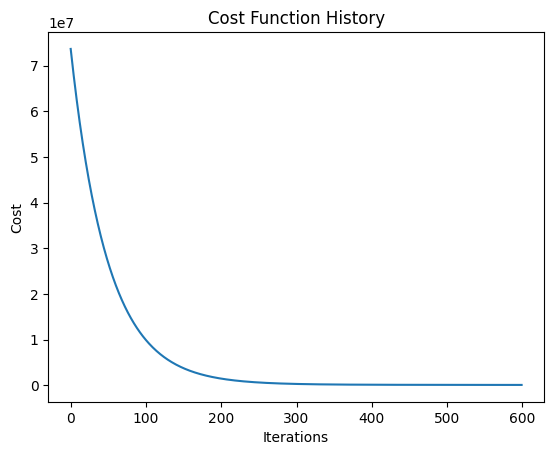

In [84]:
plt.plot(range(iters), J_hist)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost Function History')
plt.show()